In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Dropout,add

In [ ]:
Base_dir=r"D:\storygen\flickr8k"
working_dir='models/best_model2.keras'

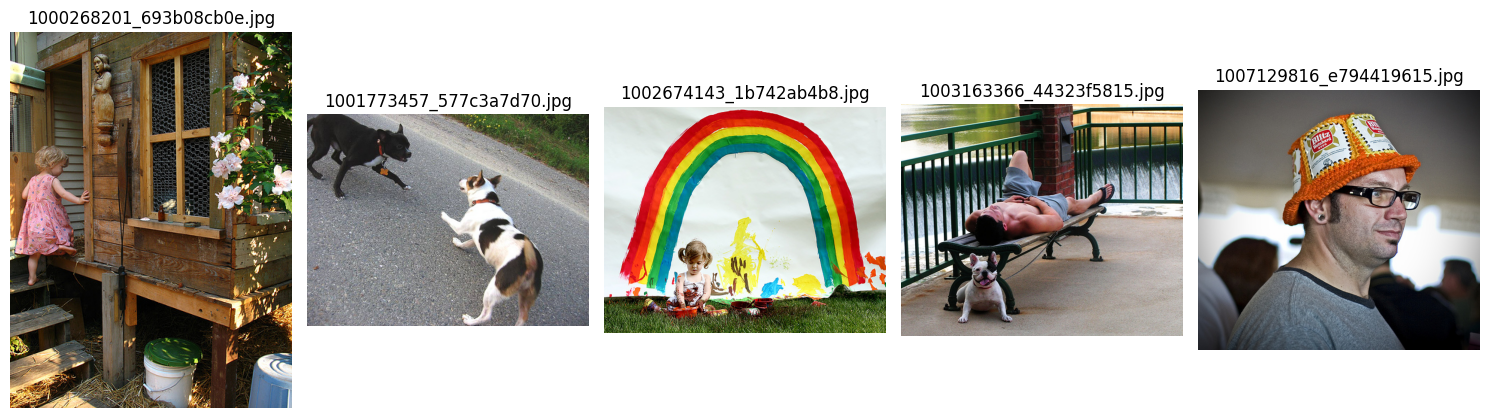

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image


Base_dir =  r"D:\storygen\flickr8k"


image_dir = os.path.join(Base_dir, "Images")
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

#First 5 images
image_files = image_files[:5]


plt.figure(figsize=(15, 5))


for i, image_name in enumerate(image_files, 1):
    # Construct the full image path
    img_path = os.path.join(image_dir, image_name)


    image = Image.open(img_path)
    plt.subplot(1, 5, i)
    plt.imshow(image)
    plt.title(image_name)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
data = pd.read_csv(r"D:\storygen\flickr8k\captions.txt")
data

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [ ]:
model=EfficientNetB0()
model=Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [ ]:
features={}
directory=os.path.join(Base_dir,'Images')
for img_name in tqdm(os.listdir(directory)):
    img_path=directory +'/'+ img_name
    image=load_img(img_path,target_size=(224,224))
    image=img_to_array(image)
    image=image.reshape(1,image.shape[0],image.shape[1],image.shape[2])
    image=preprocess_input(image)
    feature=model.predict(image,verbose=0)
    image_id=img_name.split('.')[0]
    features[image_id]=feature

100%|██████████| 8091/8091 [23:14<00:00,  5.80it/s]


In [ ]:
with open(os.path.join(Base_dir,'captions.txt'),'r') as File:
    next(File)
    captions_file=File.read()

In [ ]:
mapping = {}
for line in tqdm(captions_file.split('\n')):
    tokens = line.split(',')
    #Skips lines with fewer than 2 characters (likely blank lines)
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

100%|██████████| 40456/40456 [00:00<00:00, 1056817.69it/s]


In [ ]:
import re

def preprocessing(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i].lower()
            caption = re.sub(r'[^a-z]', ' ', caption)
            caption = re.sub(r'\s+', ' ', caption)
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption

In [ ]:
all_captions = [caption for key in mapping for caption in mapping[key]]

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in all_captions)

In [ ]:
image_ids = list(mapping.keys())

#Train 80%;Test20%
train, test = train_test_split(image_ids, test_size=0.2, random_state=42)

In [ ]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = [] , [] ,[]
    n = 0
    while True:
        for key in data_keys:
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                if len(seq) < 2:  # We Skip sequences that are too short to create (input, output) pairs
                    continue
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            n += 1 # Moving to Next Part after one part's completition
            if n == batch_size:
                yield {"image": np.array(X1), "text": np.array(X2)}, np.array(y)
                X1.clear()
                X2.clear()
                y.clear()
                n = 0

In [ ]:
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.models import Model



inputs1 = Input(shape=(1280,), name='image')
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,), name='text')
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256, return_sequences=False, use_cudnn=False)(se2)


decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)


model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')


model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None, 37)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image (InputLayer)  │ (None, 1280)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 37, 256)   │  2,174,464 │ text[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 1280)      │          0 │ image[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 37, 256)   │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 37)        │          0 │ text[0][0]        │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │    327,936 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 256)       │    525,312 │ dropout_3[0][0],  │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256)       │          0 │ dense_3[0][0],    │
│                     │                   │            │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │     65,792 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 8494)      │  2,182,958 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,276,462 (20.13 MB)

 Trainable params: 5,276,462 (20.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    dpi=55,
    show_layer_activations=False,
    show_trainable=True
)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

earlystop = EarlyStopping(monitor='loss', patience=3, verbose=1, restore_best_weights=True)


checkpoint = ModelCheckpoint(
    'checkpoints/best_model2.keras',
    monitor='loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

callbacks = [earlystop, checkpoint]

In [ ]:
from keras.layers import LSTM

units = 256
decoder_lstm = LSTM(units, return_sequences=True, return_state=True, use_cudnn=False)

In [ ]:
epochs = 10
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    print(f"Epoch {i+1}/{epochs}")
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator,
              epochs=1,
              steps_per_epoch=steps,
              verbose=1,
              callbacks=callbacks)

Epoch 1/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 6.1904
Epoch 1: loss improved from inf to 5.36561, saving model to checkpoints/best_model2.keras
202/202 ━━━━━━━━━━━━━━━━━━━━ 548s 3s/step - loss: 6.1864
Restoring model weights from the end of the best epoch: 1.
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 4.1161
Epoch 1: loss improved from 5.36561 to 3.94962, saving model to checkpoints/best_model2.keras
202/202 ━━━━━━━━━━━━━━━━━━━━ 592s 3s/step - loss: 4.1153
Restoring model weights from the end of the best epoch: 1.
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 3.5638
Epoch 1: loss improved from 3.94962 to 3.48943, saving model to checkpoints/best_model2.keras
202/202 ━━━━━━━━━━━━━━━━━━━━ 629s 3s/step - loss: 3.5634
Restoring model weights from the end of the best epoch: 1.
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 3.2586
Epoch 1: loss improved from 3.48943 to 3.21264, saving model to checkpoints/best_model2.keras
202/202 ━━━━━━━━

In [ ]:
import tensorflow as tf

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
# Make sure this prints at least 1 GPU

epochs = 50
batch_size = 32
steps = len(train) // batch_size

for i in range(10, epochs):
    print(f"Epoch {i+1}/{epochs}")
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator,
              epochs=1,
              steps_per_epoch=steps,
              verbose=1,
              callbacks=callbacks)


Num GPUs Available: 0
Epoch 11/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 2.3335
Epoch 1: loss improved from 2.39157 to 2.31917, saving model to checkpoints/best_model2.keras
202/202 ━━━━━━━━━━━━━━━━━━━━ 839s 4s/step - loss: 2.3334
Restoring model weights from the end of the best epoch: 1.
Epoch 12/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 2.2677
Epoch 1: loss improved from 2.31917 to 2.25543, saving model to checkpoints/best_model2.keras
202/202 ━━━━━━━━━━━━━━━━━━━━ 862s 4s/step - loss: 2.2676
Restoring model weights from the end of the best epoch: 1.
Epoch 13/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 2.2106
Epoch 1: loss improved from 2.25543 to 2.19701, saving model to checkpoints/best_model2.keras
202/202 ━━━━━━━━━━━━━━━━━━━━ 907s 4s/step - loss: 2.2105
Restoring model weights from the end of the best epoch: 1.
Epoch 14/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 2.1583
Epoch 1: loss improved from 2.19701 to 2.14635, saving model to checkpoints/best

In [ ]:
def convert_to_word(number, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == number:
            return word
    return None


def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        y_pred = model.predict([image, sequence], verbose=0)
        y_pred = np.argmax(y_pred)
        word = convert_to_word(y_pred, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break

    return in_text

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(Base_dir, "Images", image_name)
    image = Image.open(img_path)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print(y_pred)
    plt.imshow(image)

startseq climbing a rock climber climbing a cliff face with his ropes and rope attached to him to the right and the person in the red hardhat is attached to the rock wall below below and attached to


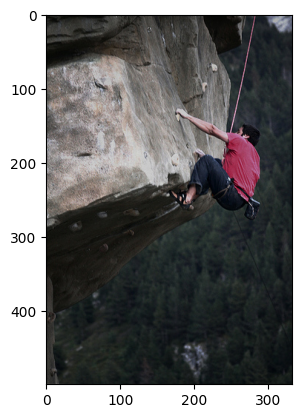

In [ ]:
generate_caption("997722733_0cb5439472.jpg")

startseq a small child in a blue shirt is jumping off of a wooden playhouse in a yard of a house in the background by a wooden house in front of a wooden cabin or some women in


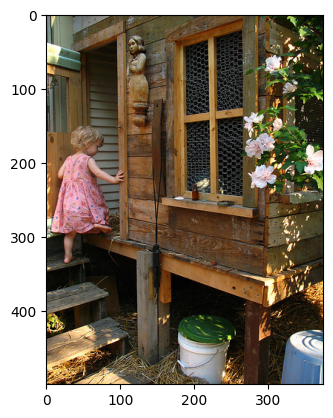

In [ ]:
generate_caption("1000268201_693b08cb0e.jpg")

startseq dogs are playing with a toy in a grassy field while a yellow dog sits nearby behind it on the grass by the house nearby the house house nearby by the house house nearby the house nearby


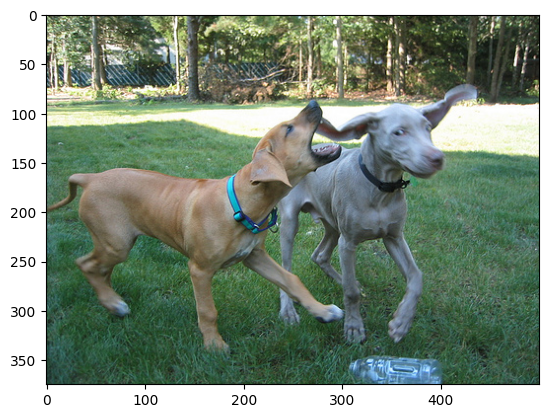

In [ ]:
generate_caption("123889082_d3751e0350.jpg")